In [1]:
pip install -q flwr[simulation]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 1.5

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import flwr as fl
import logging
import math
import warnings

# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

logging.basicConfig(format="%(asctime)s %(levelname)s %(message)s", datefmt="%H:%M:%S", level=logging.INFO)

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support

#Tensorflow para redes neuronales
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Activation
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import SGD
# from tensorflow.keras import backend as K

from typing import List, Tuple, Dict, Optional
from flwr.common import Metrics
import time

# Cambiamos el display para que nos muestre todas las columnas
pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Cargamos los datasets sampleados

In [4]:
DIRECTORIO = "/content/drive/My Drive/UNIVERSIDAD/TFG/Flower/datasets/"


In [5]:
df_cic_sampled = pd.read_csv(os.path.join(DIRECTORIO, "cicids_sampled.csv"), skipinitialspace=True, error_bad_lines=False )

<ipython-input-5-dd721b120a09>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_cic_sampled = pd.read_csv(os.path.join(DIRECTORIO, "cicids_sampled.csv"), skipinitialspace=True, error_bad_lines=False )


In [6]:
df_nb15_sampled = pd.read_csv(os.path.join(DIRECTORIO, "nb15_sampled.csv"), skipinitialspace=True, error_bad_lines=False )

<ipython-input-6-407920532375>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_nb15_sampled = pd.read_csv(os.path.join(DIRECTORIO, "nb15_sampled.csv"), skipinitialspace=True, error_bad_lines=False )


In [7]:
df_toniot_sampled = pd.read_csv(os.path.join(DIRECTORIO, "toniot_sampled.csv"), skipinitialspace=True, error_bad_lines=False )

<ipython-input-7-cc2ff887f1ab>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_toniot_sampled = pd.read_csv(os.path.join(DIRECTORIO, "toniot_sampled.csv"), skipinitialspace=True, error_bad_lines=False )


In [8]:
df_cic_sampled['Attack'].value_counts()

Benign           880623
DDoS              73558
DoS               25574
Bot                7595
Brute Force        6525
Infilteration      6108
injection            17
Name: Attack, dtype: int64

In [9]:
df_nb15_sampled['Attack'].value_counts()

Benign            960078
Exploits           13187
Fuzzers             9377
Generic             6976
Reconnaissance      5352
DoS                 2455
Analysis             969
Backdoor             925
Shellcode            617
Worms                 64
Name: Attack, dtype: int64

Muchas menos ocurrencias de la clase Benign

In [10]:
df_toniot_sampled['Attack'].value_counts()

Benign        359618
scanning      223060
xss           145234
DDoS          119871
password       68014
DoS            42057
injection      40578
Backdoor         945
mitm             437
ransomware       186
Name: Attack, dtype: int64

# Detección de ataques de forma binaria



Eliminamos el atributo 'IPV4_SRC_ADDR', ya que además de ser un String, un atacante puede modificar sus direcciones ip con facilidad por lo que no es un buen indicador de ataques. Y probamos en primera instancia la capacidad de detección de ataques



In [11]:
df_cic_sampled = df_cic_sampled.drop(columns=['IPV4_SRC_ADDR','Dataset','Attack', 'IPV4_DST_ADDR'])
df_nb15_sampled = df_nb15_sampled.drop(columns=['IPV4_SRC_ADDR','Dataset','Attack', 'IPV4_DST_ADDR'])
df_toniot_sampled = df_toniot_sampled.drop(columns=['IPV4_SRC_ADDR','Dataset','Attack', 'IPV4_DST_ADDR'])

In [ ]:
# info(), describe()
df_cic_sampled.describe()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1.000000e+06,1.000000e+06,1000000.000000,1000000.00000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000
mean,52659.920038,1284.360772,10.548983,12.403945,1.740838e+03,22.161183,7.421483e+03,10.060070,76.299446,75.594511,21.262760,5.740977e+05,23.260189,11.283958,71.586959,71.695324,564.173963,53.587941,49.403967,564.173963,3.433269e+284,9.549449e+15,38.895994,0.544643,5.034912e+01,0.115312,4.762750e+06,1.400946e+07,25.067955,1.34409,0.742837,0.615475,4.541102,11521.682196,20960.230931,3243.569417,12.670189,13377.853879,3.901842,19.153562,0.0,0.119377
std,11642.282164,3772.600236,5.435479,28.713816,6.437620e+04,1038.055828,5.257403e+05,353.651708,99.070738,98.840040,28.909778,1.461522e+06,1019.594722,74.125931,56.891609,57.004592,540.273537,36.367985,19.578821,540.273537,inf,9.549185e+18,283.660998,2.983208,2.569057e+03,2.165843,1.139812e+07,9.683141e+07,1038.064961,6.03406,4.639909,4.776127,349.821967,19104.998681,25035.197726,12051.384688,47.075722,20137.412899,15.596916,26.367543,0.0,0.324232
min,0.000000,0.000000,1.000000,0.000000,2.800000e+01,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,28.000000,28.000000,0.000000,28.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,50725.000000,53.000000,6.000000,0.000000,6.900000e+01,1.000000,1.170000e+02,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,100.000000,40.000000,40.000000,100.000000,7.000000e+01,1.210000e+02,0.000000,0.000000,0.000000e+00,0.000000,5.280000e+05,7.600000e+05,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,54193.000000,80.000000,6.000000,0.000000,1.800000e+02,4.000000,3.220000e+02,3.000000,27.000000,26.000000,22.000000,0.000000e+00,0.000000,0.000000,101.000000,101.000000,191.000000,40.000000,40.000000,191.000000,2.080000e+02,3.380000e+02,0.000000,0.000000,0.000000e+00,0.000000,9.920000e+05,1.440000e+06,6.000000,1.00000,0.000000,0.000000,0.000000,8192.000000,8192.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,59507.000000,445.000000,17.000000,7.000000,1.460000e+03,9.000000,1.873000e+03,7.000000,219.000000,219.000000,27.000000,0.000000e+00,0.000000,0.000000,128.000000,128.000000,1189.000000,66.000000,65.000000,1189.000000,1.460000e+03,1.873000e+03,0.000000,0.000000,0.000000e+00,0.000000,9.096000e+06,1.376800e+07,12.000000,2.00000,1.000000,1.000000,1.000000,8192.000000,29200.000000,0.000000,0.000000,25392.000000,1.000000,60.000000,0.0,0.000000
max,65535.000000,65535.000000,58.000000,248.000000,1.652742e+07,200

# Preprocesamiento de los datasets (Por separado)

1º Eliminar valores nulos (si existen)

In [12]:
df_cic_sampled = df_cic_sampled.dropna()
df_nb15_sampled = df_nb15_sampled.dropna()
df_toniot_sampled = df_toniot_sampled.dropna()

2º Analizar la correlación de las características con las etiquetas

In [ ]:
corr_matrix = df_cic_sampled.corr()
corr_with_target = corr_matrix['Label']

# imprimir coeficientes de correlación ordenados de mayor a menor
print(corr_with_target.abs().sort_values(ascending=False))

Label                          1.000000
FLOW_DURATION_MILLISECONDS     0.749713
TCP_WIN_MAX_IN                 0.556323
DURATION_OUT                   0.373979
CLIENT_TCP_FLAGS               0.297078
TCP_FLAGS                      0.296523
PROTOCOL                       0.279349
DNS_TTL_ANSWER                 0.247652
DNS_QUERY_ID                   0.226690
MIN_TTL                        0.216128
MAX_TTL                        0.215054
LONGEST_FLOW_PKT               0.213885
MAX_IP_PKT_LEN                 0.213885
MIN_IP_PKT_LEN                 0.117293
SHORTEST_FLOW_PKT              0.096808
SRC_TO_DST_AVG_THROUGHPUT      0.096288
RETRANSMITTED_IN_BYTES         0.090447
DNS_QUERY_TYPE                 0.086552
L7_PROTO                       0.080201
NUM_PKTS_512_TO_1024_BYTES     0.079177
NUM_PKTS_256_TO_512_BYTES      0.068427
TCP_WIN_MAX_OUT                0.060339
SERVER_TCP_FLAGS               0.058076
L4_SRC_PORT                    0.057959
L4_DST_PORT                    0.057347


In [ ]:
corr_matrix2 = df_nb15_sampled.corr()
corr_with_target2 = corr_matrix2['Label']

# imprimir coeficientes de correlación ordenados de mayor a menor
print(corr_with_target2.abs().sort_values(ascending=False))

Label                          1.000000
MIN_TTL                        0.825529
MAX_TTL                        0.825493
MIN_IP_PKT_LEN                 0.482792
PROTOCOL                       0.278931
SHORTEST_FLOW_PKT              0.157629
SERVER_TCP_FLAGS               0.155445
TCP_FLAGS                      0.122071
CLIENT_TCP_FLAGS               0.117763
L4_DST_PORT                    0.106942
NUM_PKTS_UP_TO_128_BYTES       0.100721
TCP_WIN_MAX_IN                 0.092301
MAX_IP_PKT_LEN                 0.086734
LONGEST_FLOW_PKT               0.086734
DST_TO_SRC_AVG_THROUGHPUT      0.059217
DNS_QUERY_TYPE                 0.058207
OUT_PKTS                       0.053631
L4_SRC_PORT                    0.047733
FTP_COMMAND_RET_CODE           0.045093
IN_PKTS                        0.044659
RETRANSMITTED_OUT_PKTS         0.042562
TCP_WIN_MAX_OUT                0.040877
FLOW_DURATION_MILLISECONDS     0.038685
DURATION_IN                    0.037941
DNS_QUERY_ID                   0.035991


In [ ]:
corr_matrix3 = df_toniot_sampled.corr()
corr_with_target3 = corr_matrix3['Label']

# imprimir coeficientes de correlación ordenados de mayor a menor
print(corr_with_target3.abs().sort_values(ascending=False))

Label                          1.000000
TCP_WIN_MAX_IN                 0.359685
CLIENT_TCP_FLAGS               0.340647
MIN_IP_PKT_LEN                 0.327981
TCP_WIN_MAX_OUT                0.316535
MIN_TTL                        0.287622
MAX_TTL                        0.286448
LONGEST_FLOW_PKT               0.253742
MAX_IP_PKT_LEN                 0.253742
SERVER_TCP_FLAGS               0.221145
TCP_FLAGS                      0.202697
FLOW_DURATION_MILLISECONDS     0.201501
PROTOCOL                       0.123603
DURATION_OUT                   0.121629
DNS_QUERY_ID                   0.121494
DNS_TTL_ANSWER                 0.111608
L4_DST_PORT                    0.106291
SRC_TO_DST_AVG_THROUGHPUT      0.089090
L7_PROTO                       0.088349
DURATION_IN                    0.086446
DST_TO_SRC_AVG_THROUGHPUT      0.078260
SHORTEST_FLOW_PKT              0.071366
DNS_QUERY_TYPE                 0.049713
FTP_COMMAND_RET_CODE           0.038195
NUM_PKTS_UP_TO_128_BYTES       0.033960


3º A partir de las correlaciones elegir los atributos

In [12]:
feature_names_CIC = [
    "FLOW_DURATION_MILLISECONDS",
    "TCP_WIN_MAX_IN",
    "DURATION_OUT",
    "CLIENT_TCP_FLAGS",
    "TCP_FLAGS",
    "PROTOCOL",
    "DNS_TTL_ANSWER",
    "DNS_QUERY_ID",
    "MIN_TTL",
    "MAX_TTL",
    "LONGEST_FLOW_PKT",
    "MAX_IP_PKT_LEN",
    "MIN_IP_PKT_LEN",
    "SHORTEST_FLOW_PKT",
    "SRC_TO_DST_AVG_THROUGHPUT",
    "RETRANSMITTED_IN_BYTES",
    "DNS_QUERY_TYPE",
    "L7_PROTO",
    "NUM_PKTS_512_TO_1024_BYTES",
    "NUM_PKTS_256_TO_512_BYTES",
    "TCP_WIN_MAX_OUT",
    "SERVER_TCP_FLAGS"
]
feature_names_CIC_extend = [
    "FLOW_DURATION_MILLISECONDS",
    "TCP_WIN_MAX_IN",
    "DURATION_OUT",
    "CLIENT_TCP_FLAGS",
    "TCP_FLAGS",
    "PROTOCOL",
    "DNS_TTL_ANSWER",
    "DNS_QUERY_ID",
    "MIN_TTL",
    "MAX_TTL",
    "LONGEST_FLOW_PKT",
    "MAX_IP_PKT_LEN",
    "MIN_IP_PKT_LEN",
    "SHORTEST_FLOW_PKT",
    "SRC_TO_DST_AVG_THROUGHPUT",
    "RETRANSMITTED_IN_BYTES",
    "DNS_QUERY_TYPE",
    "L7_PROTO",
    "NUM_PKTS_512_TO_1024_BYTES",
    "NUM_PKTS_256_TO_512_BYTES",
    "TCP_WIN_MAX_OUT",
    "SERVER_TCP_FLAGS",
    "L4_SRC_PORT",
    "L4_DST_PORT",
    "DURATION_IN",
    "NUM_PKTS_128_TO_256_BYTES",
    "DST_TO_SRC_AVG_THROUGHPUT",
    "NUM_PKTS_UP_TO_128_BYTES",
    "IN_PKTS",
    "IN_BYTES",
    "RETRANSMITTED_OUT_PKTS",
    "RETRANSMITTED_IN_PKTS",
    "ICMP_TYPE",
    "ICMP_IPV4_TYPE",
    "RETRANSMITTED_OUT_BYTES"
]
features_names_nb15 = [
    "MIN_TTL",
    "MAX_TTL",
    "MIN_IP_PKT_LEN",
    "PROTOCOL",
    "SHORTEST_FLOW_PKT",
    "SERVER_TCP_FLAGS",
    "TCP_FLAGS",
    "CLIENT_TCP_FLAGS",
    "L4_DST_PORT",
    "NUM_PKTS_UP_TO_128_BYTES",
    "TCP_WIN_MAX_IN",
    "MAX_IP_PKT_LEN",
    "LONGEST_FLOW_PKT",
    "DST_TO_SRC_AVG_THROUGHPUT",
    "DNS_QUERY_TYPE",
    "OUT_PKTS",
    "L4_SRC_PORT",
    "FTP_COMMAND_RET_CODE",
    "IN_PKTS",
    "RETRANSMITTED_OUT_PKTS",
    "TCP_WIN_MAX_OUT",
    "FLOW_DURATION_MILLISECONDS",
]

features_name_toniot = [
    "TCP_WIN_MAX_IN",
    "CLIENT_TCP_FLAGS",
    "MIN_IP_PKT_LEN",
    "TCP_WIN_MAX_OUT",
    "MIN_TTL",
    "MAX_TTL",
    "LONGEST_FLOW_PKT",
    "MAX_IP_PKT_LEN",
    "SERVER_TCP_FLAGS",
    "TCP_FLAGS",
    "FLOW_DURATION_MILLISECONDS",
    "PROTOCOL",
    "DURATION_OUT",
    "DNS_QUERY_ID",
    "DNS_TTL_ANSWER",
    "L4_DST_PORT",
    "SRC_TO_DST_AVG_THROUGHPUT",
    "L7_PROTO",
    "DURATION_IN",
    "DST_TO_SRC_AVG_THROUGHPUT",
    "SHORTEST_FLOW_PKT",
    "DNS_QUERY_TYPE",
]


In [ ]:
# # Change inf value with maximum value of each class
# inf_rows = df_cic_sampled[df_cic_sampled.isin([np.inf]).any(axis=1)].shape[0]
# logging.info("Replace Inf in {} rows with maximum value of each class.".format(inf_rows))
# # Temporary replace inf with NaN
# df_cic_sampled = df_cic_sampled.replace([np.inf], np.nan)
# # Replace inf with maximum value of each class in this dataset
# df_cic_sampled.iloc[:, df_cic_sampled.columns != "Label"] = df_cic_sampled.groupby("Label").transform(lambda x: x.fillna(x.max()))

# # Change negative value with minimum positive value of each class
# logging.info("Replace negative values with minimum value of each class.")
# # Temporary replace negative value with NaN
# df_cic_sampled.iloc[:, :-1][df_cic_sampled.iloc[:, :-1] < 0] = np.nan
# # Replace negative value with minimum value of each class in this dataset
# df_cic_sampled.iloc[:, df_cic_sampled.columns != "Label"] = df_cic_sampled.groupby("Label").transform(lambda x: x.fillna(x.min()))

## Balanceo (opcional)

CIC

In [ ]:
indexes = []
benign_included_count = 0
for index, row in df_cic_sampled.iterrows():
    if row['Label'] != 0:
        indexes.append(index)
    else:
        if benign_included_count < 200000:
            indexes.append(index)
            benign_included_count += 1
df_cic_sampled = df_cic_sampled.loc[indexes]

NB15

In [ ]:
indexes = []
benign_included_count = 0
for index, row in df_nb15_sampled.iterrows():
    if row['Label'] != 0:
        indexes.append(index)
    else:
        if benign_included_count < 200000:
            indexes.append(index)
            benign_included_count += 1
df_nb15_sampled = df_nb15_sampled.loc[indexes]

TONIOT 

In [ ]:
indexes = []
benign_included_count = 0
for index, row in df_toniot_sampled.iterrows():
    if row['Label'] == 0:
        indexes.append(index)
    else:
        if benign_included_count < 200000:
            indexes.append(index)
            benign_included_count += 1
df_toniot_sampled = df_toniot_sampled.loc[indexes]

# Partición del dataset en entrenamiento y test

In [13]:
# Escalador opcional
scaler = MinMaxScaler()

In [14]:
# X_cic = df_cic_sampled.drop(['Label'], axis=1)
X_cic = df_cic_sampled[feature_names_CIC]
y_cic = df_cic_sampled['Label']

# Split data into train and test
X_train_cic, X_test_cic, y_train_cic, y_test_cic = train_test_split(X_cic, y_cic,shuffle=True, test_size=0.2, random_state=42)

scaler.fit(X_train_cic)
X_train_cic = scaler.transform(X_train_cic)
X_test_cic = scaler.transform(X_test_cic)

print("X Train shape:",X_train_cic.shape)
print("Y Train shape:",y_train_cic.shape)
print("X Test shape:",X_test_cic.shape)
print("Y Test shape:",y_test_cic.shape)

X Train shape: (800000, 22)
Y Train shape: (800000,)
X Test shape: (200000, 22)
Y Test shape: (200000,)


In [15]:
df_cic_sampled['Label'].value_counts()

0    880623
1    119377
Name: Label, dtype: int64

In [16]:
# X_nb15 = df_nb15_sampled.drop(['Label'], axis=1) # axis=0 se referiria a filas
X_nb15 = df_nb15_sampled[features_names_nb15]
y_nb15 = df_nb15_sampled['Label']

# Split data into train and test
X_train_nb15, X_test_nb15, y_train_nb15, y_test_nb15 = train_test_split(X_nb15, y_nb15,shuffle=True, test_size=0.2, random_state=42)

scaler.fit(X_train_nb15)
X_train_nb15 = scaler.transform(X_train_nb15)
X_test_nb15 = scaler.transform(X_test_nb15)

print("X Train shape:",X_train_nb15.shape)
print("Y Train shape:",y_train_nb15.shape)
print("X Test shape:",X_test_nb15.shape)
print("Y Test shape:",y_test_nb15.shape)

X Train shape: (800000, 22)
Y Train shape: (800000,)
X Test shape: (200000, 22)
Y Test shape: (200000,)


In [17]:
df_nb15_sampled['Label'].value_counts()

0    960078
1     39922
Name: Label, dtype: int64

In [18]:
# X_toniot = df_toniot_sampled.drop(['Label'], axis=1)
X_toniot = df_toniot_sampled[features_name_toniot]
y_toniot = df_toniot_sampled['Label']

# Split data into train and test
X_train_toniot, X_test_toniot, y_train_toniot, y_test_toniot = train_test_split(X_toniot, y_toniot,shuffle=True, test_size=0.2, random_state=42)

scaler.fit(X_train_toniot)
X_train_toniot = scaler.transform(X_train_toniot)
X_test_toniot = scaler.transform(X_test_toniot)

print("X Train shape:",X_train_toniot.shape)
print("Y Train shape:",y_train_toniot.shape)
print("X Test shape:",X_test_toniot.shape)
print("Y Test shape:",y_test_toniot.shape)

X Train shape: (800000, 22)
Y Train shape: (800000,)
X Test shape: (200000, 22)
Y Test shape: (200000,)


In [19]:
df_toniot_sampled['Label'].value_counts()

1    640382
0    359618
Name: Label, dtype: int64

# Modelo Regresión Logística (Centralizado)
Métricas del CIC-ids2017

In [20]:
log_reg = LogisticRegression(random_state=10, solver = 'lbfgs', max_iter=300)
log_reg.fit(X_train_cic, y_train_cic)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=300, random_state=10)

In [21]:
y_pred_test = log_reg.predict(X_test_cic)


In [22]:
# Imprimir métricas de clasificación
from sklearn.metrics import classification_report
print("The Training Accuracy is: ", log_reg.score(X_train_cic, y_train_cic))

# Accuracy on Test
print("The Testing Accuracy is: ", log_reg.score(X_test_cic, y_test_cic))
print(classification_report(y_test_cic, y_pred_test))

The Training Accuracy is:  0.96692625
The Testing Accuracy is:  0.966185
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    176068
           1       0.89      0.81      0.85     23932

    accuracy                           0.97    200000
   macro avg       0.93      0.90      0.92    200000
weighted avg       0.97      0.97      0.97    200000



In [23]:
log_reg = LogisticRegression(random_state=5, solver = 'lbfgs', max_iter=300)
log_reg.fit(X_train_nb15, y_train_nb15)

LogisticRegression(max_iter=300, random_state=5)

In [24]:
y_pred_test = log_reg.predict(X_test_nb15)


In [25]:
# Imprimir métricas de clasificación
from sklearn.metrics import classification_report
print("The Training Accuracy is: ", log_reg.score(X_train_nb15, y_train_nb15))

# Accuracy on Test
print("The Testing Accuracy is: ", log_reg.score(X_test_nb15, y_test_nb15))
print(classification_report(y_test_nb15, y_pred_test))

The Training Accuracy is:  0.99122125
The Testing Accuracy is:  0.99113
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    192119
           1       0.87      0.92      0.89      7881

    accuracy                           0.99    200000
   macro avg       0.93      0.96      0.94    200000
weighted avg       0.99      0.99      0.99    200000



In [26]:
log_reg = LogisticRegression(random_state=10, solver = 'lbfgs', max_iter=300)
log_reg.fit(X_train_toniot, y_train_toniot)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=300, random_state=10)

In [27]:
y_pred_test = log_reg.predict(X_test_toniot)


In [28]:
# Imprimir métricas de clasificación
from sklearn.metrics import classification_report
print("The Training Accuracy is: ", log_reg.score(X_train_toniot, y_train_toniot))

# Accuracy on Test
print("The Testing Accuracy is: ", log_reg.score(X_test_toniot, y_test_toniot))
print(classification_report(y_test_toniot, y_pred_test))

The Training Accuracy is:  0.7781625
The Testing Accuracy is:  0.777495
              precision    recall  f1-score   support

           0       0.66      0.79      0.72     71920
           1       0.87      0.77      0.82    128080

    accuracy                           0.78    200000
   macro avg       0.76      0.78      0.77    200000
weighted avg       0.79      0.78      0.78    200000



# Modelo centralizado (haciendo append de los 3 datasets) Modif_DJ


In [41]:
# Unir los tres datasets en uno solo (centralizar data)
df_CL = pd.concat([df_cic_sampled, df_nb15_sampled, df_toniot_sampled]).reset_index(drop=True)

In [42]:
corr_matrix = df_CL.corr()
corr_with_target = corr_matrix['Label']

# imprimir coeficientes de correlación ordenados de mayor a menor
print(corr_with_target.abs().sort_values(ascending=False))

Label                          1.000000
FLOW_DURATION_MILLISECONDS     0.358211
DURATION_OUT                   0.247715
ICMP_IPV4_TYPE                 0.216849
ICMP_TYPE                      0.216846
MIN_IP_PKT_LEN                 0.179694
TCP_WIN_MAX_IN                 0.170197
L7_PROTO                       0.136646
DST_TO_SRC_AVG_THROUGHPUT      0.130929
FTP_COMMAND_RET_CODE           0.116022
DNS_QUERY_ID                   0.097358
SRC_TO_DST_AVG_THROUGHPUT      0.095173
RETRANSMITTED_OUT_PKTS         0.093743
MAX_IP_PKT_LEN                 0.077875
LONGEST_FLOW_PKT               0.077875
SERVER_TCP_FLAGS               0.076662
MIN_TTL                        0.074499
RETRANSMITTED_OUT_BYTES        0.072261
MAX_TTL                        0.070939
RETRANSMITTED_IN_PKTS          0.065863
DURATION_IN                    0.045818
TCP_WIN_MAX_OUT                0.044965
PROTOCOL                       0.043801
L4_SRC_PORT                    0.042911
SHORTEST_FLOW_PKT              0.037906


In [58]:
features_all = [
    "FLOW_DURATION_MILLISECONDS",
    "DURATION_OUT",
    "ICMP_IPV4_TYPE",
    "ICMP_TYPE",
    "MIN_IP_PKT_LEN",
    "TCP_WIN_MAX_IN",
    "L7_PROTO",
    "DST_TO_SRC_AVG_THROUGHPUT",
    "FTP_COMMAND_RET_CODE",
    "DNS_QUERY_ID",
    "SRC_TO_DST_AVG_THROUGHPUT",
    "RETRANSMITTED_OUT_PKTS",
    "MAX_IP_PKT_LEN",
    "LONGEST_FLOW_PKT",
    "SERVER_TCP_FLAGS",
    "MIN_TTL",
    "RETRANSMITTED_OUT_BYTES",
    "MAX_TTL",
    "RETRANSMITTED_IN_PKTS",
    "DURATION_IN",
    "TCP_WIN_MAX_OUT",
    "PROTOCOL",
]


In [59]:
print("df_cic_sampled shape:",df_cic_sampled[feature_names_CIC].shape)
print("df_nb15_sampled shape:",df_nb15_sampled[features_names_nb15].shape)
print("df_toniot_sampled shape:",df_toniot_sampled[features_name_toniot].shape)
print("df_concatenado shape:",df_CL[features_all].shape)

# X_nb15 = df_nb15_sampled.drop(['Label'], axis=1) # axis=0 se referiria a filas
X_CL = df_CL[features_all]
y_CL = df_CL['Label']


print("\n:")
# print("df_cic_sampled shape:",df_CL[feature_names].shape)
print("Frecuencias labels:\n",y_CL.value_counts())
print("Distribucion labels:\n",y_CL.value_counts()/sum(y_CL.value_counts()))

# Split data into train and test
X_train_CL, X_test_CL, y_train_CL, y_test_CL = train_test_split(X_CL, y_CL,shuffle=True, test_size=0.2, random_state=42)

scaler.fit(X_train_CL)
X_train_CL = scaler.transform(X_train_CL)
X_test_CL = scaler.transform(X_test_CL)

print("\n:")
print("X Train shape:",X_train_CL.shape)
print("Y Train shape:",y_train_CL.shape)
print("X Test shape:",X_test_CL.shape)
print("Y Test shape:",y_test_CL.shape)

df_cic_sampled shape: (1000000, 22)
df_nb15_sampled shape: (1000000, 22)
df_toniot_sampled shape: (1000000, 22)
df_concatenado shape: (3000000, 22)

:
Frecuencias labels:
 0    2200319
1     799681
Name: Label, dtype: int64
Distribucion labels:
 0    0.73344
1    0.26656
Name: Label, dtype: float64

:
X Train shape: (2400000, 22)
Y Train shape: (2400000,)
X Test shape: (600000, 22)
Y Test shape: (600000,)


In [60]:
log_reg_CL = LogisticRegression(random_state=10, solver = 'lbfgs', max_iter=300)
log_reg_CL.fit(X_train_CL, y_train_CL)

# Predecir en test
y_pred_test = log_reg_CL.predict(X_test_CL)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [61]:
# Imprimir métricas de clasificación
print("The Training Accuracy is: ", log_reg_CL.score(X_train_CL, y_train_CL))

# Accuracy on Test
print("The Testing Accuracy is: ", log_reg_CL.score(X_test_CL, y_test_CL))
print(classification_report(y_test_CL, y_pred_test))

The Training Accuracy is:  0.78247625
The Testing Accuracy is:  0.7827916666666667
              precision    recall  f1-score   support

           0       0.79      0.95      0.87    440090
           1       0.70      0.32      0.44    159910

    accuracy                           0.78    600000
   macro avg       0.75      0.64      0.65    600000
weighted avg       0.77      0.78      0.75    600000



In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import log_loss

def test_model(model, X_test, Y_test):
    loss = log_loss(Y_test, model.predict_proba(X_test))
    y_pred = model.predict(X_test_CL)
    acc = accuracy_score(y_pred, Y_test)
    pre = precision_score(y_pred, Y_test, average='weighted',zero_division = 0)
    rec = recall_score(y_pred, Y_test, average='weighted',zero_division = 0)
    f1s = f1_score(y_pred, Y_test, average='weighted',zero_division = 0)

    return loss, acc, pre, rec, f1s

global_loss_test, global_acc_test, global_pre_test, global_rec_test, global_f1s_test = test_model(log_reg_CL, X_test_CL, y_test_CL)

print("\n\nFINAL RESULTS: ===========================================================================================================================================================================================")
print('Test: global_acc: {:} | global_pre: {} | global_rec: {} | global_f1s: {}'.format(global_acc_test, global_pre_test, global_rec_test, global_f1s_test))



FINAL RESULTS: ===========================================================================================================================================================================================
Test: global_acc: 0.7827916666666667 | global_pre: 0.8741234331948401 | global_rec: 0.7827916666666667 | global_f1s: 0.8135856774932064


# Modelo federado

## Definimos la función para cliente (tutorial flwr scikit-learn)

In [63]:
from typing import Tuple, Union, List
import numpy as np
from sklearn.linear_model import LogisticRegression

#  define varios tipos de datos personalizados en Python utilizando la biblioteca NumPy
XY = Tuple[np.ndarray, np.ndarray]
Dataset = Tuple[XY, XY]
LogRegParams = Union[XY, Tuple[np.ndarray]] # puede ser o un XY o un solo array
XYList = List[XY]

# Función recibe un modelo de regresión logística como entrada y devuelve los parámetros del modelo: coeficientes e intercepción
def get_model_parameters(model: LogisticRegression) -> LogRegParams:
    """Returns the paramters of a sklearn LogisticRegression model."""
    if model.fit_intercept:
        params = [
            model.coef_,
            model.intercept_,
        ]
    else:
        params = [
            model.coef_,
        ]
    return params

# Actualiza el modelo con los nuevos parámetros
def set_model_params(
    model: LogisticRegression, params: LogRegParams
) -> LogisticRegression:
    """Sets the parameters of a sklean LogisticRegression model. los coeficientes b1,b2... y la intercep b0"""
    model.coef_ = params[0]
    if model.fit_intercept:
        model.intercept_ = params[1]
    return model

# Establece los parámetros iniciales del modelo de regresión logística como ceros, necesarios ya que los parámetros del modelo no se 
# inicializan hasta que se llama a la función fit
def set_initial_params(model: LogisticRegression):
    """Sets initial parameters as zeros Required since model params are
    uninitialized until model.fit is called.

    But server asks for initial parameters from clients at launch. Refer
    to sklearn.linear_model.LogisticRegression documentation for more
    information.
    """
    n_classes = 2  
    n_features = 22  # Number of features in dataset
    model.classes_ = np.array([i for i in range(2)])

    model.coef_ = np.zeros((n_classes, n_features))
    if model.fit_intercept:
        model.intercept_ = np.zeros((n_classes,))






In [64]:
# Definimos la clase para cada cliente
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, model, x_train, y_train, x_test, y_test) -> None:
        self.model = model
        self.cid = cid
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test

    def get_parameters(self, config):
        print(f"[Client {self.cid}] GET_PARAMETERS")
        return get_model_parameters(self.model)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] FIT")
        set_model_params(self.model, parameters)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.model.fit(self.x_train, self.y_train)
        # print(f"Training finished for round {config['server_round']}")
        return get_model_parameters(self.model), len(self.x_train), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] EVALUATE")
        y_test_pred = self.model.predict_proba(self.x_test)
        set_model_params(self.model, parameters)
        loss = log_loss(self.y_test, y_test_pred)
        accuracy = self.model.score(self.x_test, self.y_test)
        print(f"Loss: {loss}, Accuracy: {accuracy} de {self.cid}")
        return loss, len(self.x_test), {"accuracy": accuracy}

## Define model and data partition for each client

In [66]:
# Definir lista con datasets por cada cliente (no hay necesidad de dejarla dentro de la función) Modif_DJ
client_datasets = [
  (X_train_cic, y_train_cic),
  (X_train_nb15, y_train_nb15),
  (X_train_toniot, y_train_toniot),
  ] 


# Función para definir el modelo y la partición de los datasets 
# en nuestro caso 1 dataset por cliente
def client_fn(cid: str) -> fl.client.Client:
    # Creamos modelo
    # Los datos de entrada son 41 características, todos escalares
    # Create LogisticRegression Model
    model = LogisticRegression(solver = 'lbfgs', max_iter=1, warm_start=False)

    set_initial_params(model)

    # Selecciona el conjunto de datos para el cliente específico
    print(f"Cliente: {int(cid)} DEFINIDO EL MODELO Y DATASET")
    full_X_train_cid, full_y_train_cid = client_datasets[int(cid)]

    scaler.fit(full_X_train_cid)
    full_X_train_cid = scaler.transform(full_X_train_cid)

    # Utiliza el 10% de los datos de entrenamiento del cliente para validación
    # split_idx = math.floor(len(full_X_train_cid) * 0.9)
    # X_train_cid, y_train_cid = full_X_train_cid[:split_idx], full_y_train_cid[:split_idx]
    # X_val_cid, y_val_cid = full_X_train_cid[split_idx:], full_y_train_cid[split_idx:]

    # Define train/validation data randomly Modif_DJ
    X_train_cid, X_val_cid, y_train_cid, y_val_cid = train_test_split(full_X_train_cid, full_y_train_cid,shuffle=True, test_size=0.1, random_state=42)

    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Crea y devuelve el cliente
    return FlowerClient(cid, model, X_train_cid, y_train_cid, X_val_cid, y_val_cid)



    #model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

    # Dataset federation (divide original data in desired clients)
    # Load data partition (divide dataset into NUM_CLIENTS distinct partitions)
      
    # partition_size = math.floor(len(X_train) / NUM_CLIENTS)
    # idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
    # full_X_train_cid = X_train[idx_from:idx_to]
    # full_y_train_cid = y_train[idx_from:idx_to]

    # # Use 10% of the client's training data for validation
    # split_idx = math.floor(len(full_X_train_cid) * 0.9)
    # X_train_cid, y_train_cid = full_X_train_cid[:split_idx], full_y_train_cid[:split_idx]
    # X_val_cid, y_val_cid = full_X_train_cid[split_idx:], full_y_train_cid[split_idx:]

    # Create and return client
    # return FlowerClient(model, X_train_cid, y_train_cid, X_val_cid, y_val_cid)



## Define strategy and fit FL

In [69]:
def fit_round(server_round: int) -> Dict:
    """Send round number to client."""
    return {"server_round": server_round}



In [70]:
# The `evaluate` function will be by Flower called after every round
def evaluate_REGLOG_CL(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = LogisticRegression(solver = 'lbfgs', max_iter=1, warm_start=True)
    
    set_initial_params(net) # First initialize parameters
    set_model_params(net, parameters) # Update model with the latest parameters
    loss, accuracy, precision, recall, f1score  = test_model(net, X_test_CL, y_test_CL)
    print(f"@@@@@@ Server-side evaluation loss {loss} / accuracy {accuracy} / f1score {f1score} @@@@@@")
    return loss, {"accuracy": accuracy,"precision": precision,"recall": recall,"f1score": f1score}

def retrieve_global_metrics(
    hist: None,
    metric_type: None,
    metric: None,
    best_metric: None,
) -> None:
    """Function to plot from Flower server History.
    Parameters
    ----------
    hist : History
        Object containing evaluation for all rounds.
    metric_type : Literal["centralized", "distributed"]
        Type of metric to retrieve.
    metric : Literal["accuracy","precision","recall","f1score"]
        Metric to retrieve.
    """
    metric_dict = (
        hist.metrics_centralized
        if metric_type == "centralized"
        else hist.metrics_distributed
    )
    rounds, values = zip(*metric_dict[metric])
    if best_metric:
      metric_return = max(values)
    else:
      metric_return = values[-1]
    return metric_return

In [71]:
NUM_CLIENTS=3
comms_round=5 #Modif_DJ

# Create FedAvg strategy
strategy=fl.server.strategy.FedAvg(
        min_fit_clients=3,  # Never sample less than 10 clients for training
        min_evaluate_clients=3,  # Never sample less than 5 clients for evaluation
        min_available_clients=3,  # Wait until at least 75 clients are available
        # on_fit_config_fn=fit_round,
        evaluate_fn=evaluate_REGLOG_CL, # Modif_DJ
    
)

start_time = time.time()
# Start simulation of the federated learning process
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=comms_round), #Modif_DJ
    strategy=strategy,
)

# Get total training time
training_time = time.time() - start_time
print("Training time: %s seconds" % (training_time))

INFO flwr 2023-04-18 09:48:51,741 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-18 09:48:56,130	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-18 09:48:58,827 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 11152647782.0, 'CPU': 40.0, 'memory': 22305295566.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 11152647782.0, 'CPU': 40.0, 'memory': 22305295566.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-04-18 09:48:58,830 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-04-18 09:48:58,832 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client


(launch_and_get_parameters pid=23140) Cliente: 0 DEFINIDO EL MODELO Y DATASET


INFO flwr 2023-04-18 09:49:00,163 | server.py:274 | Received initial parameters from one random client
INFO:flwr:Received initial parameters from one random client
INFO flwr 2023-04-18 09:49:00,165 | server.py:88 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters


(launch_and_get_parameters pid=23140) [Client 0] GET_PARAMETERS


INFO flwr 2023-04-18 09:49:01,222 | server.py:91 | initial parameters (loss, other metrics): 0.6931471805599454, {'accuracy': 0.7334833333333334, 'precision': 1.0, 'recall': 0.7334833333333334, 'f1score': 0.8462536895845552}
INFO:flwr:initial parameters (loss, other metrics): 0.6931471805599454, {'accuracy': 0.7334833333333334, 'precision': 1.0, 'recall': 0.7334833333333334, 'f1score': 0.8462536895845552}
INFO flwr 2023-04-18 09:49:01,225 | server.py:101 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2023-04-18 09:49:01,228 | server.py:215 | fit_round 1: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 1: strategy sampled 3 clients (out of 3)


@@@@@@ Server-side evaluation loss 0.6931471805599454 / accuracy 0.7334833333333334 / f1score 0.8462536895845552 @@@@@@
(launch_and_fit pid=23140) Cliente: 0 DEFINIDO EL MODELO Y DATASET
(launch_and_fit pid=23140) [Client 0] FIT
(launch_and_fit pid=23094) Cliente: 2 DEFINIDO EL MODELO Y DATASET
(launch_and_fit pid=23143) Cliente: 1 DEFINIDO EL MODELO Y DATASET
(launch_and_fit pid=23094) [Client 2] FIT


DEBUG flwr 2023-04-18 09:49:03,467 | server.py:229 | fit_round 1 received 3 results and 0 failures
DEBUG:flwr:fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-04-18 09:49:03,474 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


(launch_and_fit pid=23143) [Client 1] FIT


INFO flwr 2023-04-18 09:49:04,493 | server.py:116 | fit progress: (1, 0.6396706942081312, {'accuracy': 0.7334833333333334, 'precision': 1.0, 'recall': 0.7334833333333334, 'f1score': 0.8462536895845552}, 3.265275845999895)
INFO:flwr:fit progress: (1, 0.6396706942081312, {'accuracy': 0.7334833333333334, 'precision': 1.0, 'recall': 0.7334833333333334, 'f1score': 0.8462536895845552}, 3.265275845999895)
DEBUG flwr 2023-04-18 09:49:04,496 | server.py:165 | evaluate_round 1: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 3)


@@@@@@ Server-side evaluation loss 0.6396706942081312 / accuracy 0.7334833333333334 / f1score 0.8462536895845552 @@@@@@
(launch_and_evaluate pid=23140) Cliente: 0 DEFINIDO EL MODELO Y DATASET
(launch_and_evaluate pid=23094) Cliente: 1 DEFINIDO EL MODELO Y DATASET
(launch_and_evaluate pid=23143) Cliente: 2 DEFINIDO EL MODELO Y DATASET
(launch_and_evaluate pid=23140) [Client 0] EVALUATE
(launch_and_evaluate pid=23094) [Client 1] EVALUATE
(launch_and_evaluate pid=23143) [Client 2] EVALUATE


DEBUG flwr 2023-04-18 09:49:05,917 | server.py:179 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2023-04-18 09:49:05,920 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-04-18 09:49:05,921 | server.py:215 | fit_round 2: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=23140) Loss: 0.6931471805599453, Accuracy: 0.8817625 de 0
(launch_and_evaluate pid=23143) Loss: 0.6931471805599453, Accuracy: 0.357725 de 2
(launch_and_evaluate pid=23094) Loss: 0.6931471805599453, Accuracy: 0.9595375 de 1
(launch_and_fit pid=23140) Cliente: 0 DEFINIDO EL MODELO Y DATASET
(launch_and_fit pid=23094) Cliente: 1 DEFINIDO EL MODELO Y DATASET
(launch_and_fit pid=23143) Cliente: 2 DEFINIDO EL MODELO Y DATASET
(launch_and_fit pid=23140) [Client 0] FIT
(launch_and_fit pid=23094) [Client 1] FIT
(launch_and_fit pid=23143) [Client 2] FIT


DEBUG flwr 2023-04-18 09:49:07,592 | server.py:229 | fit_round 2 received 3 results and 0 failures
DEBUG:flwr:fit_round 2 received 3 results and 0 failures
INFO flwr 2023-04-18 09:49:08,644 | server.py:116 | fit progress: (2, 0.6396706942081312, {'accuracy': 0.7334833333333334, 'precision': 1.0, 'recall': 0.7334833333333334, 'f1score': 0.8462536895845552}, 7.41544937599997)
INFO:flwr:fit progress: (2, 0.6396706942081312, {'accuracy': 0.7334833333333334, 'precision': 1.0, 'recall': 0.7334833333333334, 'f1score': 0.8462536895845552}, 7.41544937599997)
DEBUG flwr 2023-04-18 09:49:08,646 | server.py:165 | evaluate_round 2: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 3)


@@@@@@ Server-side evaluation loss 0.6396706942081312 / accuracy 0.7334833333333334 / f1score 0.8462536895845552 @@@@@@
(launch_and_evaluate pid=23140) Cliente: 0 DEFINIDO EL MODELO Y DATASET
(launch_and_evaluate pid=23094) Cliente: 2 DEFINIDO EL MODELO Y DATASET
(launch_and_evaluate pid=23143) Cliente: 1 DEFINIDO EL MODELO Y DATASET
(launch_and_evaluate pid=23140) [Client 0] EVALUATE
(launch_and_evaluate pid=23094) [Client 2] EVALUATE
(launch_and_evaluate pid=23143) [Client 1] EVALUATE
(launch_and_evaluate pid=23140) Loss: 0.6931471805599453, Accuracy: 0.8817625 de 0


DEBUG flwr 2023-04-18 09:49:09,539 | server.py:179 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-04-18 09:49:09,548 | server.py:215 | fit_round 3: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=23094) Loss: 0.6931471805599453, Accuracy: 0.357725 de 2
(launch_and_evaluate pid=23143) Loss: 0.6931471805599453, Accuracy: 0.9595375 de 1
(launch_and_fit pid=23140) Cliente: 1 DEFINIDO EL MODELO Y DATASET
(launch_and_fit pid=23094) Cliente: 2 DEFINIDO EL MODELO Y DATASET
(launch_and_fit pid=23143) Cliente: 0 DEFINIDO EL MODELO Y DATASET
(launch_and_fit pid=23140) [Client 1] FIT
(launch_and_fit pid=23094) [Client 2] FIT
(launch_and_fit pid=23143) [Client 0] FIT


DEBUG flwr 2023-04-18 09:49:11,377 | server.py:229 | fit_round 3 received 3 results and 0 failures
DEBUG:flwr:fit_round 3 received 3 results and 0 failures
INFO flwr 2023-04-18 09:49:12,336 | server.py:116 | fit progress: (3, 0.6396706942081312, {'accuracy': 0.7334833333333334, 'precision': 1.0, 'recall': 0.7334833333333334, 'f1score': 0.8462536895845552}, 11.107389468000065)
INFO:flwr:fit progress: (3, 0.6396706942081312, {'accuracy': 0.7334833333333334, 'precision': 1.0, 'recall': 0.7334833333333334, 'f1score': 0.8462536895845552}, 11.107389468000065)
DEBUG flwr 2023-04-18 09:49:12,339 | server.py:165 | evaluate_round 3: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 3)


@@@@@@ Server-side evaluation loss 0.6396706942081312 / accuracy 0.7334833333333334 / f1score 0.8462536895845552 @@@@@@
(launch_and_evaluate pid=23140) Cliente: 0 DEFINIDO EL MODELO Y DATASET
(launch_and_evaluate pid=23094) Cliente: 1 DEFINIDO EL MODELO Y DATASET
(launch_and_evaluate pid=23143) Cliente: 2 DEFINIDO EL MODELO Y DATASET
(launch_and_evaluate pid=23094) [Client 1] EVALUATE
(launch_and_evaluate pid=23140) [Client 0] EVALUATE
(launch_and_evaluate pid=23143) [Client 2] EVALUATE


DEBUG flwr 2023-04-18 09:49:13,731 | server.py:179 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-04-18 09:49:13,733 | server.py:215 | fit_round 4: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=23140) Loss: 0.6931471805599453, Accuracy: 0.8817625 de 0
(launch_and_evaluate pid=23094) Loss: 0.6931471805599453, Accuracy: 0.9595375 de 1
(launch_and_evaluate pid=23143) Loss: 0.6931471805599453, Accuracy: 0.357725 de 2
(launch_and_fit pid=23140) Cliente: 0 DEFINIDO EL MODELO Y DATASET
(launch_and_fit pid=23094) Cliente: 1 DEFINIDO EL MODELO Y DATASET
(launch_and_fit pid=23143) Cliente: 2 DEFINIDO EL MODELO Y DATASET
(launch_and_fit pid=23140) [Client 0] FIT
(launch_and_fit pid=23094) [Client 1] FIT
(launch_and_fit pid=23143) [Client 2] FIT


DEBUG flwr 2023-04-18 09:49:15,573 | server.py:229 | fit_round 4 received 3 results and 0 failures
DEBUG:flwr:fit_round 4 received 3 results and 0 failures
INFO flwr 2023-04-18 09:49:16,579 | server.py:116 | fit progress: (4, 0.6396706942081312, {'accuracy': 0.7334833333333334, 'precision': 1.0, 'recall': 0.7334833333333334, 'f1score': 0.8462536895845552}, 15.35105982999994)
INFO:flwr:fit progress: (4, 0.6396706942081312, {'accuracy': 0.7334833333333334, 'precision': 1.0, 'recall': 0.7334833333333334, 'f1score': 0.8462536895845552}, 15.35105982999994)
DEBUG flwr 2023-04-18 09:49:16,581 | server.py:165 | evaluate_round 4: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 3)


@@@@@@ Server-side evaluation loss 0.6396706942081312 / accuracy 0.7334833333333334 / f1score 0.8462536895845552 @@@@@@
(launch_and_evaluate pid=23140) Cliente: 1 DEFINIDO EL MODELO Y DATASET
(launch_and_evaluate pid=23094) Cliente: 2 DEFINIDO EL MODELO Y DATASET
(launch_and_evaluate pid=23143) Cliente: 0 DEFINIDO EL MODELO Y DATASET
(launch_and_evaluate pid=23140) [Client 1] EVALUATE
(launch_and_evaluate pid=23094) [Client 2] EVALUATE
(launch_and_evaluate pid=23143) [Client 0] EVALUATE
(launch_and_evaluate pid=23140) Loss: 0.6931471805599453, Accuracy: 0.9595375 de 1


DEBUG flwr 2023-04-18 09:49:17,558 | server.py:179 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-04-18 09:49:17,560 | server.py:215 | fit_round 5: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=23143) Loss: 0.6931471805599453, Accuracy: 0.8817625 de 0
(launch_and_evaluate pid=23094) Loss: 0.6931471805599453, Accuracy: 0.357725 de 2
(launch_and_fit pid=23140) Cliente: 0 DEFINIDO EL MODELO Y DATASET
(launch_and_fit pid=23094) Cliente: 1 DEFINIDO EL MODELO Y DATASET
(launch_and_fit pid=23143) Cliente: 2 DEFINIDO EL MODELO Y DATASET
(launch_and_fit pid=23140) [Client 0] FIT
(launch_and_fit pid=23094) [Client 1] FIT
(launch_and_fit pid=23143) [Client 2] FIT


DEBUG flwr 2023-04-18 09:49:18,952 | server.py:229 | fit_round 5 received 3 results and 0 failures
DEBUG:flwr:fit_round 5 received 3 results and 0 failures
INFO flwr 2023-04-18 09:49:19,975 | server.py:116 | fit progress: (5, 0.6396706942081312, {'accuracy': 0.7334833333333334, 'precision': 1.0, 'recall': 0.7334833333333334, 'f1score': 0.8462536895845552}, 18.747110557000042)
INFO:flwr:fit progress: (5, 0.6396706942081312, {'accuracy': 0.7334833333333334, 'precision': 1.0, 'recall': 0.7334833333333334, 'f1score': 0.8462536895845552}, 18.747110557000042)
DEBUG flwr 2023-04-18 09:49:19,977 | server.py:165 | evaluate_round 5: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 3)


@@@@@@ Server-side evaluation loss 0.6396706942081312 / accuracy 0.7334833333333334 / f1score 0.8462536895845552 @@@@@@
(launch_and_evaluate pid=23140) Cliente: 0 DEFINIDO EL MODELO Y DATASET
(launch_and_evaluate pid=23094) Cliente: 1 DEFINIDO EL MODELO Y DATASET
(launch_and_evaluate pid=23143) Cliente: 2 DEFINIDO EL MODELO Y DATASET
(launch_and_evaluate pid=23140) [Client 0] EVALUATE
(launch_and_evaluate pid=23094) [Client 1] EVALUATE
(launch_and_evaluate pid=23143) [Client 2] EVALUATE
(launch_and_evaluate pid=23143) Loss: 0.6931471805599453, Accuracy: 0.357725 de 2


DEBUG flwr 2023-04-18 09:49:20,916 | server.py:179 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
INFO flwr 2023-04-18 09:49:20,926 | server.py:144 | FL finished in 19.697567031000062
INFO:flwr:FL finished in 19.697567031000062
INFO flwr 2023-04-18 09:49:20,929 | app.py:202 | app_fit: losses_distributed [(1, 0.6931471805599453), (2, 0.6931471805599453), (3, 0.6931471805599453), (4, 0.6931471805599453), (5, 0.6931471805599453)]
INFO:flwr:app_fit: losses_distributed [(1, 0.6931471805599453), (2, 0.6931471805599453), (3, 0.6931471805599453), (4, 0.6931471805599453), (5, 0.6931471805599453)]
INFO flwr 2023-04-18 09:49:20,931 | app.py:203 | app_fit: metrics_distributed {}
INFO:flwr:app_fit: metrics_distributed {}
INFO flwr 2023-04-18 09:49:20,933 | app.py:204 | app_fit: losses_centralized [(0, 0.6931471805599454), (1, 0.6396706942081312), (2, 0.6396706942081312), (3, 0.6396706942081312), (4, 0.6396706942081312), (5, 0.63967

(launch_and_evaluate pid=23140) Loss: 0.6931471805599453, Accuracy: 0.8817625 de 0
Training time: 29.21477484703064 seconds
(launch_and_evaluate pid=23094) Loss: 0.6931471805599453, Accuracy: 0.9595375 de 1


## Check accuracy of FL


In [72]:
# def plot_metric_from_history(
#     hist: None,
#     save_plot_path: None,
#     metric_type: None,
# ) -> None:
#     """Function to plot from Flower server History.
#     Parameters
#     ----------
#     hist : History
#         Object containing evaluation for all rounds.
#     save_plot_path : Path
#         Folder to save the plot to.
#     metric_type : Literal["centralized", "distributed"]
#         Type of metric to plot.
#     """
#     metric_dict = (
#         hist.metrics_centralized
#         if metric_type == "centralized"
#         else hist.metrics_distributed
#     )
#     rounds, values = zip(*metric_dict["accuracy"])
#     plt.plot(np.asarray(rounds), np.asarray(values), label="FedAvg")
#     # plt.savefig(Path(save_plot_path) / Path(f"{metric_type}_metrics{suffix}.png"))
#     # plt.close()

def plot_metric_from_history(
    hist: None,
    save_plot_path: None,
    metric_type: None,
    metric: None,
) -> None:
    """Function to plot from Flower server History.
    Parameters
    ----------
    hist : History
        Object containing evaluation for all rounds.
    save_plot_path : Path
        Folder to save the plot to.
    metric_type : Literal["centralized", "distributed"]
        Type of metric to plot.
    metric : Literal["accuracy","precision","recall","f1score"]
        Metric to plot.
    """
    metric_dict = (
        hist.metrics_centralized
        if metric_type == "centralized"
        else hist.metrics_distributed
    )
    rounds, values = zip(*metric_dict[metric])
    # plt.plot(np.asarray(rounds), np.asarray(values), label="FedAvg")
    plt.plot(np.asarray(rounds), np.asarray(values), linewidth=5, label='Test')
    plt.legend(fontsize=45)
    plt.xlabel('Communication round', fontsize=40)
    plt.ylabel(metric, fontsize=50)
    plt.title(metric, fontsize=60)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    # plt.ylim(min(min(min(commun_metrics))) - 0.05, max(max(max(commun_metrics))) + 0.05)
    plt.ylim(0, 1)
    # plt.savefig(Path(save_plot_path) / Path(f"{metric_type}_metrics{suffix}.png"))
    # plt.close()

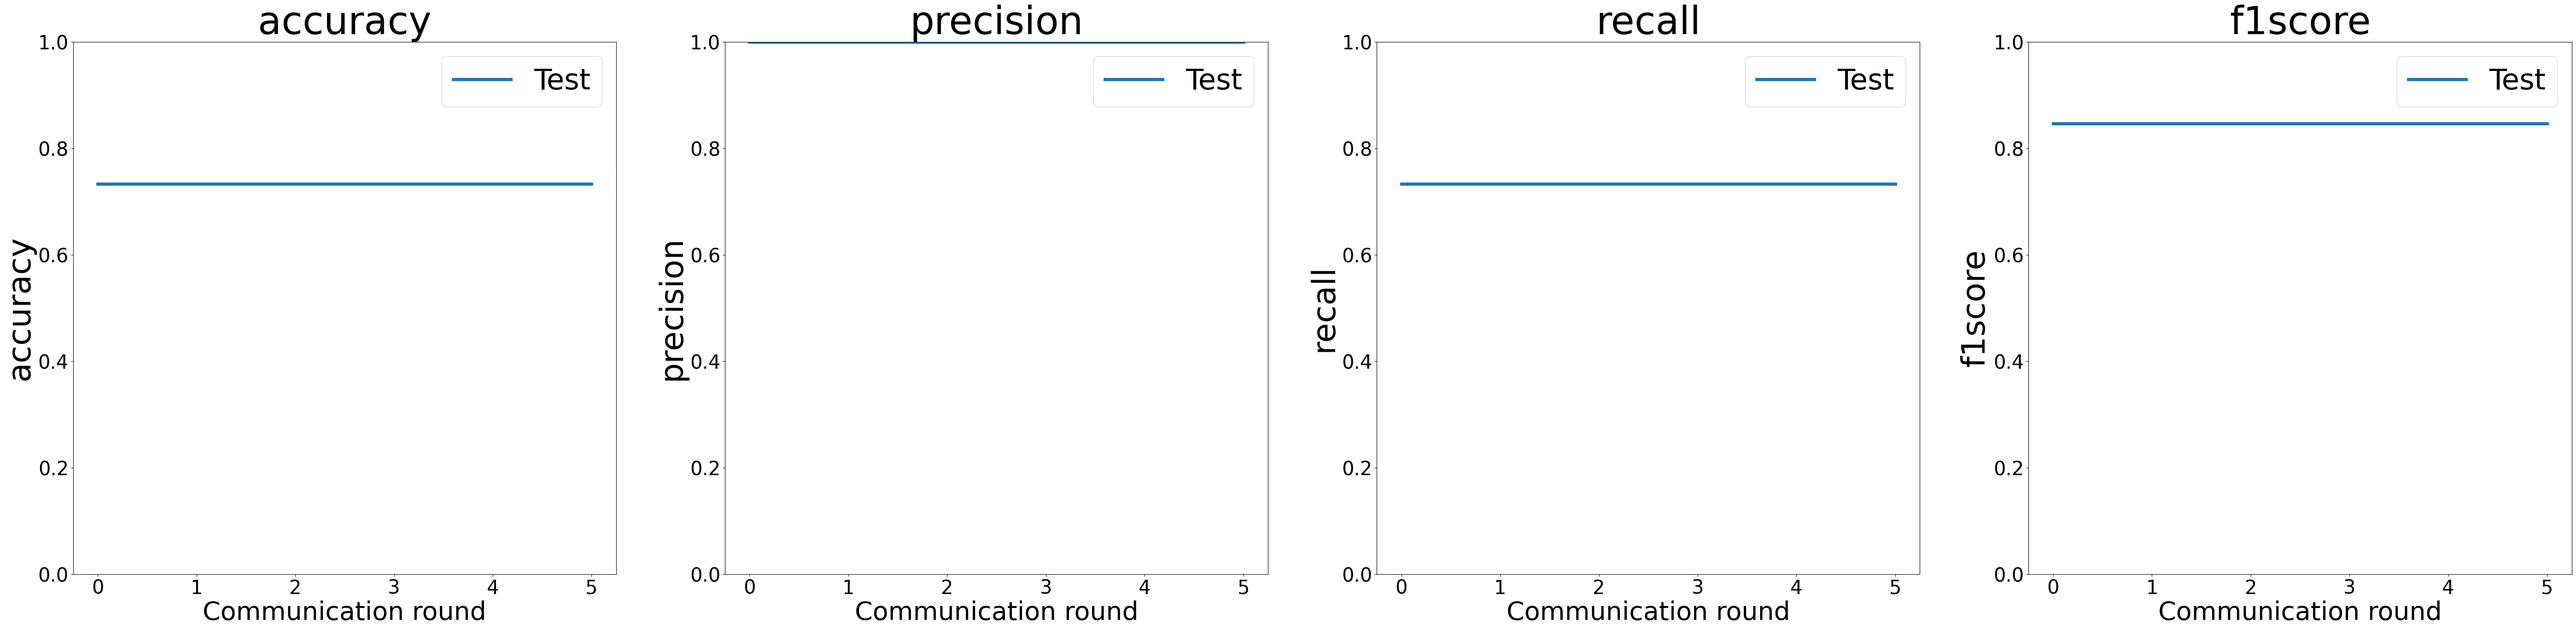

In [73]:
# Define metrics to plot
metrics_show = ["accuracy","precision","recall","f1score"]

# Define dimensions for plot
f, axs = plt.subplots(1,len(metrics_show),figsize=(70,15))

# Loop over the communication round history and metrics
for i in range(len(metrics_show)):
  plt.subplot(1, len(metrics_show), i + 1)
  plot_metric_from_history(history,"any","centralized",metrics_show[i])